In [216]:
import ticktack
import pandas
from jax.numpy import arange, sin, pi, array, mean, greater, less, equal, where
from scipy.optimize import minimize
import matplotlib.pyplot as plt

The basic question is what is the probability of detecting consecutive events based on the distribution of the data. The first step then will be to determine the distribution of the data. This will be done be resampling the points after the event has been removed.

In [227]:
def sine(t):
    """
    Generates a simple sinusoidal production function
    """
    return 1.88 + 0.18 * 1.88 * sin(2 * pi / 11 * t + 1.25)

parameters = array([120.0, 775, 776])

def rect(t, p=parameters):
    """
    Generates a rectangular miyake event. p is a dictionary of parameters
    """
    condition = equal(greater(t, 775.), less(t, 776.))
    return where(condition, 20.0, 0.0)

def prod(t):
    return sine(t) + rect(t)

In [228]:
annual_samples = 48                  # 4 samples per month
sample_times = arange(-360.0, 790.0)  # Times at which to collect samples
growth_bools = array([0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0])

In [229]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()
model, steady_state = cbm.run(sample_times, annual_samples, 
    production=prod, steady_state_production=1.88)

In [230]:
troposphere = cbm.bin_data( # Bins the data into annual values
    model[:, 2],   # Selecting only the years that I have data for 
    annual_samples,                         # Number of samples per year 
    sample_times,                           # Times to return the binned values for 
    growth_bools                            # Boolean mask of growth seasons
)

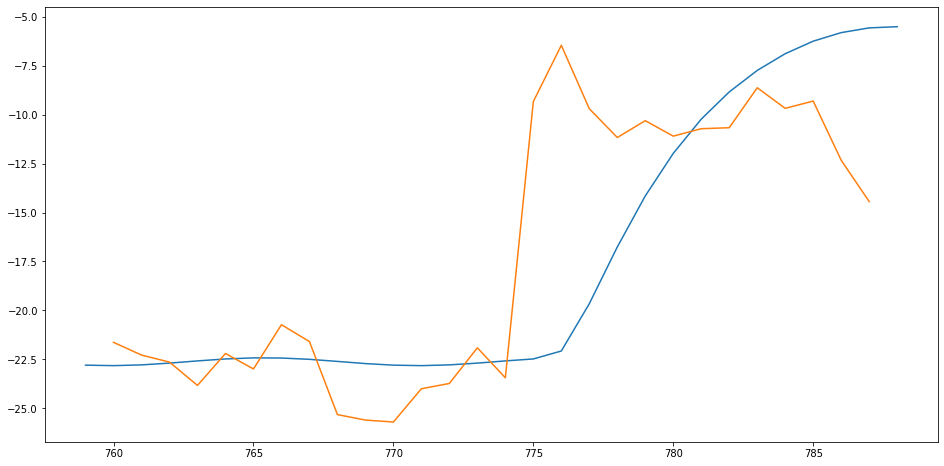

In [231]:
miyake = pandas.read_csv("Miyake12.csv", sep=" ")

troposphere = 1000 * (troposphere - steady_state[2]) / steady_state[2]
troposphere = troposphere + mean(array([*miyake["d14c"][0:4]]))

plt.figure("Model")
plt.plot(sample_times[-31:-1], troposphere[-31:-1])
plt.plot(miyake["year"], miyake["d14c"])

So the data contains underlying trends that I want to remove so that I can get a better picture of the signal to noise ratio. I might start of by fitting the ideal event. I can do this using the infrastructure that Q has put in place.